# Project Overview

Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many waterpoints already established in the country, but some are in need of repair while others have failed altogether.

Can we predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, can we predict which pumps are functional, which need some repairs, and which don't work at all? We will predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.


<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/">Tanzanian Water Well Data</a>
 
This dataset is part of an active competition until April 31, 2021!



# Import packages

We will be using the following packages in our project

In [5]:
import pandas as pd
import numpy as np
import sys
import zipfile
import folium
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb
# from mlxtend.classifier import StackingClassifier

# Data

#### Import Data

In [6]:
X = pd.read_csv("../../references/training_set_values.csv", index_col = 'id')

In [7]:
y = pd.read_csv("../../references/training_set_labels.csv", index_col = 'id')['status_group']

In [8]:
unlabeled_df = pd.read_csv("../../references/test_set_values.csv", index_col = 'id')

#### Feature info

<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/">Link to information about features</a>

In [37]:
# amount_tsh - Total static head (amount water available to waterpoint)
# date_recorded - The date the row was entered - do not include
# funder - Who funded the well
# gps_height - Altitude of the well
# installer - Organization that installed the well
# longitude - GPS coordinate - do not include
# latitude - GPS coordinate - do not include
# wpt_name - Name of the waterpoint if there is one
# num_private -
# basin - Geographic water basin
# subvillage - Geographic location
# region - Geographic location
# region_code - Geographic location (coded)
# district_code - Geographic location (coded)
# lga - Geographic location
# ward - Geographic location
# population - Population around the well
# public_meeting - True/False - ?
# recorded_by - Group entering this row of data
# scheme_management - Who operates the waterpoint
# scheme_name - Who operates the waterpoint
# permit - If the waterpoint is permitted
# construction_year - Year the waterpoint was constructed
# extraction_type - The kind of extraction the waterpoint uses
# extraction_type_group - The kind of extraction the waterpoint uses
# extraction_type_class - The kind of extraction the waterpoint uses
# management - How the waterpoint is managed
# management_group - How the waterpoint is managed
# payment - What the water costs
# payment_type - What the water costs
# water_quality - The quality of the water
# quality_group - The quality of the water
# quantity - The quantity of water
# quantity_group - The quantity of water
# source - The source of the water
# source_type - The source of the water
# source_class - The source of the water
# waterpoint_type - The kind of waterpoint
# waterpoint_type_group - The kind of waterpoint

### Maps

#### Processing Well Data for Geospacial Visualization

In [38]:
df_loc = X.join(y)[['longitude', 'latitude', 'status_group']]
df_loc = df_loc[df_loc['longitude']!=0]


test_df_loc = unlabeled_df[['longitude', 'latitude']]
test_df_loc = test_df_loc[test_df_loc['longitude']!=0]
test_df_loc['status_group'] = 'unknown'

#### Import shape files for Tanzania

These shapefiles were found through an online search. Uncomment to directly download and unzip the data to you notebook.

In [39]:
# Uncomment to download shapefiles
# ! wget -P ../../data http://stacks.stanford.edu/file/druid:tn398yw9512/data.zip

In [40]:
# Uncomment to unzip shapefiles
# with zipfile.ZipFile('../../data/data.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/shapefiles')

#### Create GeoDataFrames to Plot in GeoPandas from Data
Convert crs from 4326 to 3857 (changes latitude and logitude format for plotting)

In [224]:
# Read in our shape file as a GeoDataFrame
geo_df = gpd.read_file('../../data/shapefiles/TAN.shp')
# Convert crs from 4326 to 3857 
geo_df = geo_df.to_crs(epsg = 3857)

In [225]:
# Back to our Well Data
# Add a geometry column that holds Point objects with lat and long for our training set
# Initialize crs to 4326 and convert crs from 4326 to 3857 
df_loc['geometry'] = df_loc.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
gdf = gpd.GeoDataFrame(df_loc, geometry='geometry')
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs(epsg = 3857)

In [226]:
# Add a geometry column that holds Point objects with lat and long for our test set
# Initialize crs to 4326 and convert crs from 4326 to 3857 
test_df_loc['geometry'] = test_df_loc.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
gdf_test = gpd.GeoDataFrame(test_df_loc, geometry='geometry')
gdf_test.crs = "EPSG:4326"
gdf_test = gdf_test.to_crs(epsg = 3857)

#### Create an Interactive Folium map to show where Tanzania is

In [44]:
m = folium.Map(location=[-6.3690, 34.8888], zoom_start = 4)
m.choropleth(geo_data=geo_df, fill_color='blue', fill_opacity=0.2, line_opacity=.1)
display(m)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Geopandas plots with Contextly

We will use static GeoPandas plots with Contextily to be able to visually show large datasets.

Map of Africa with Tanzania Highlighted

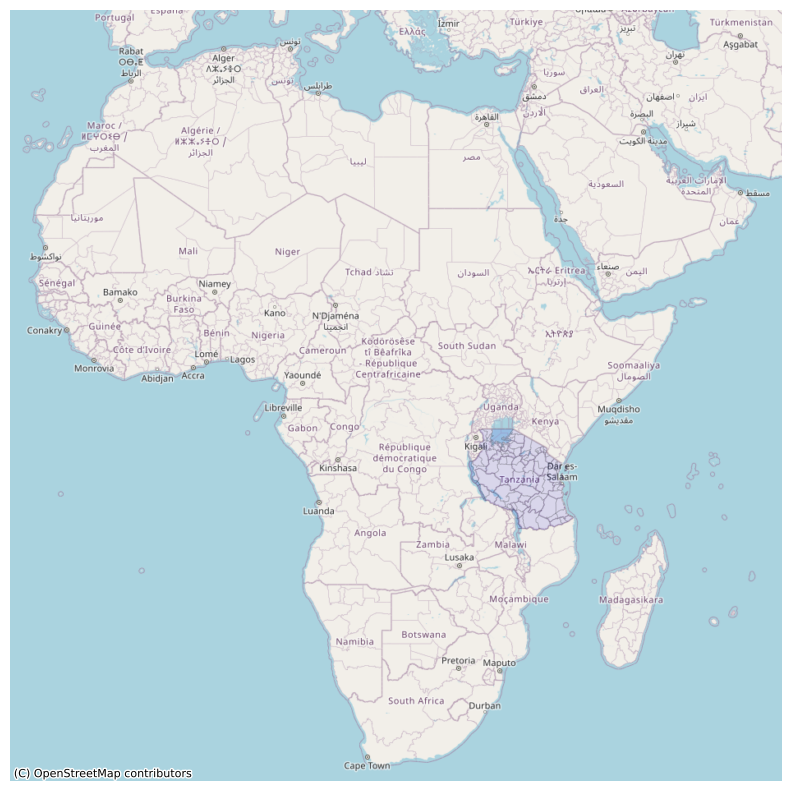

In [196]:
plt.style.use('default')
sns.set_context("paper", font_scale=1)

fig, ax = plt.subplots(figsize=(8,8))
geo_df.plot(ax=ax, color = 'blue', edgecolor = 'k', alpha = .1)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-5500000, maxx+2500000)
ax.set_ylim(miny-3000000, maxy+5000000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik) 
#source=ctx.providers.OpenStreetMap.Mapnik) lots of styles to choose from
# plt.title('Tanzanian Water Wells')

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Africa.jpg');

#### Zoomed in Map of Tanzania

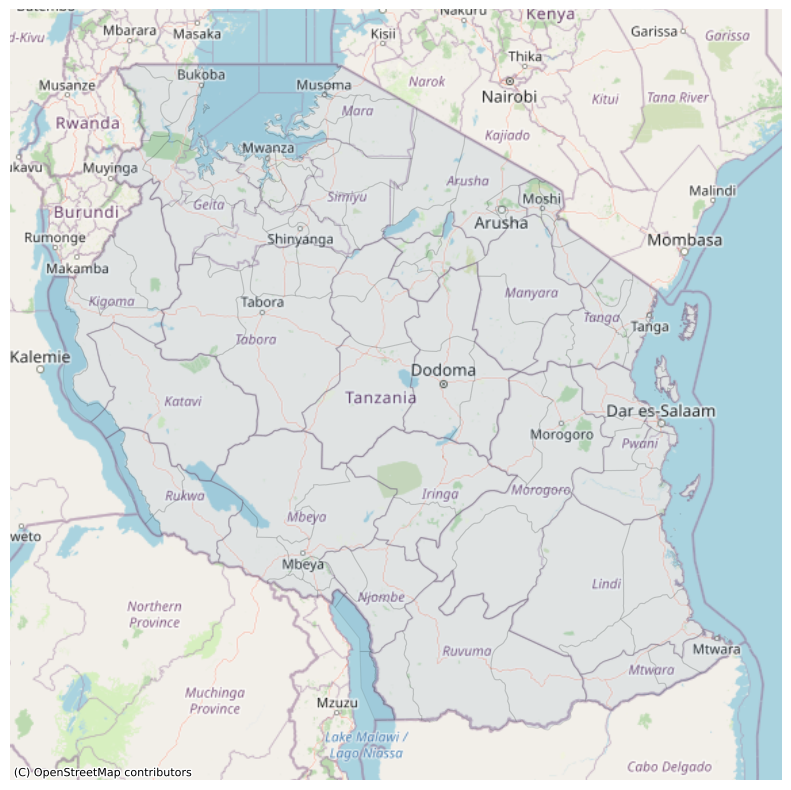

In [197]:
fig, ax = plt.subplots(figsize=(8,8))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik) #source=ctx.providers.OpenStreetMap.Mapnik) lots of styles to choose from
# plt.title('Tanzania', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania.jpg');

#### Add Wells + Status to Plot

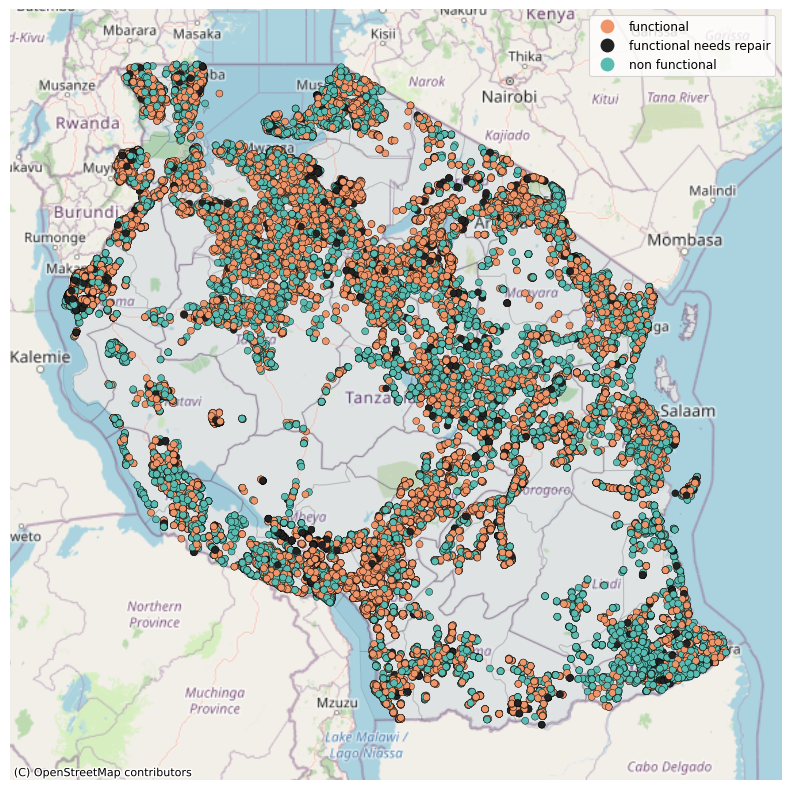

In [198]:
fig, ax = plt.subplots(figsize=(8,8))

geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

custom_palette = sns.diverging_palette(30, 180, l=70, center="dark", as_cmap=True)

# sns.color_palette(palette=[], n_colors=None, desat=None, as_cmap=False)

gdf.plot(ax=ax, column = 'status_group', marker = '.', markersize=100,
         edgecolor = 'black', cmap = custom_palette,
         linewidth=.3, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Wells', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_train.jpg', dpi = 300);

#### Plot the Test Data for wich the Status Classes are Unkown

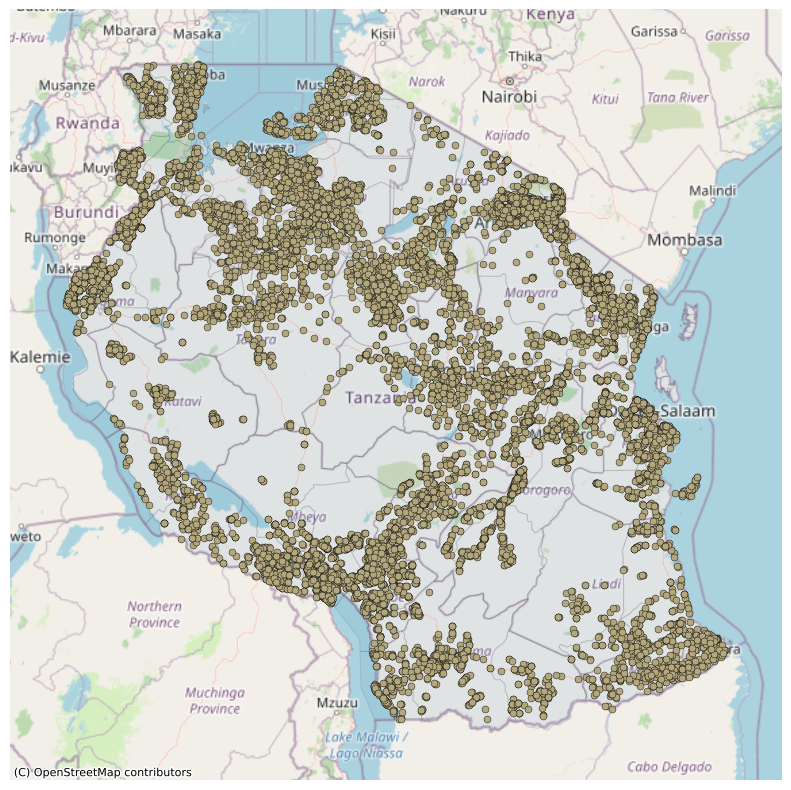

In [199]:
fig, ax = plt.subplots(figsize=(8,8))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

gdf_test.plot(ax=ax, marker = '.', markersize=100, color='#B3A77D',
              edgecolor = 'black', linewidth=.3, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Wells', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_test.jpg');

### Data Cleaning

#### Drop the columns that have too many unique categories and/or missing values

In [49]:
# X.info()

In [50]:
columns_with_na = ['permit', 'scheme_name', 'public_meeting', 'subvillage', 'installer', 'funder']
X.drop(columns_with_na, axis=1, inplace=True)

In [51]:
columns_with_specific_location_and_names = ['ward', 'wpt_name']
X.drop(columns_with_specific_location_and_names, axis=1, inplace=True)

In [52]:
X.drop('date_recorded', axis=1, inplace=True)

#### Impute scheme_management Feature NAs with "unknown"
We have determined scheme_management could be statistically significant in our model so we don't want to drop it just because it has null values

In [53]:
X['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [54]:
X['scheme_management'] = X['scheme_management'].fillna("UNKNOWN")

### EDA Visuals

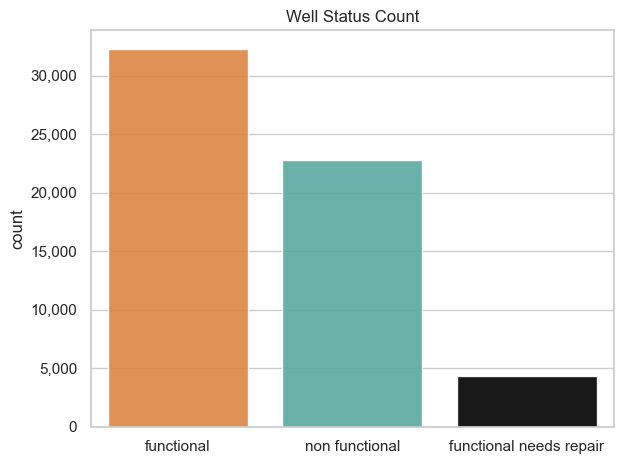

In [55]:
# Set Plot Style
plt.style.use('default')
sns.set(context = 'notebook', style = 'whitegrid')

#Create custom color palette
colors = ["#F48328", "#4DB6AC", "black"]
my_palette = sns.color_palette(colors)

#Make plot
fig, ax = plt.subplots() 
sns.countplot(y, palette=my_palette, alpha=.9)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set(xlabel=None, title = "Well Status Count")
fig.tight_layout()
plt.savefig('../../reports/figures/Well_status_dist.jpg')

In [10]:
dv = X.copy()
dv['target'] = y.copy()

(0.0, 12000.0)

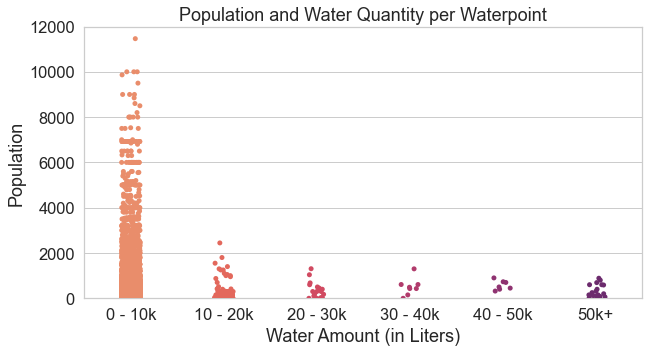

In [11]:
def mapp(x):
    if x > 50000:
        return '50k+'
    elif x > 40000:
        return '40 - 50k'
    elif x > 30000:
        return '30 - 40k'
    elif x > 20000:
        return '20 - 30k'
    elif x > 10000:
        return '10 - 20k'
    else:
        return '0 - 10k'

dv['amount'] = dv['amount_tsh'].map(mapp)

sns.set(context = 'notebook', style = 'whitegrid', font_scale=1.5)

plt.figure(figsize = (10,5))
ax = sns.stripplot( x = 'amount', y = 'population', data = dv, palette = 'flare', order = ['0 - 10k', '10 - 20k', '20 - 30k', '30 - 40k', '40 - 50k', '50k+'])
ax.set(xlabel = 'Water Amount (in Liters)', ylabel = 'Population', title = 'Population and Water Quantity per Waterpoint')
plt.ylim(0,12000)


(1960.0, 2020.1)

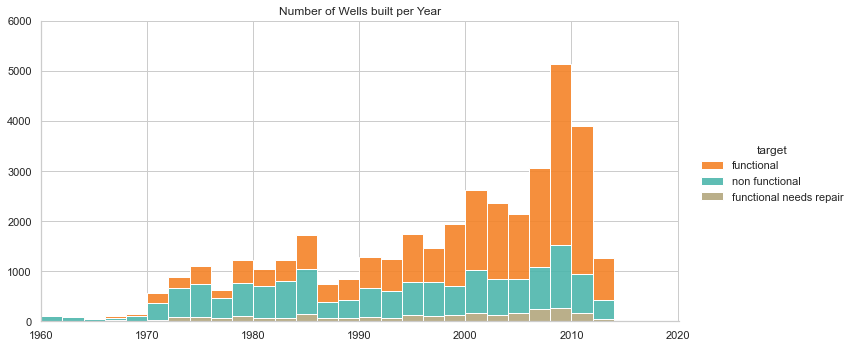

In [19]:
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
count = dv[dv.construction_year != 0]
ax = sns.displot(data = count, x = 'construction_year', kind = 'hist', stat = 'count', hue = 'target', multiple = 'stack', binwidth = 2, element = 'bars', kde = False, legend = True, palette = ['#f48328', '#4db6ac', '#b3a77d'], alpha = 0.9, aspect = 2)
ax.set(xlabel = '', ylabel = '', title = 'Number of Wells built per Year')
legend_labels = ['Functional', 'Non Functional', 'Functional needs Repair']
plt.ylim(0,6000)
plt.xlim(1960, 2020.1)


Text(0.5, 1.0, 'Number of each Pump Type')

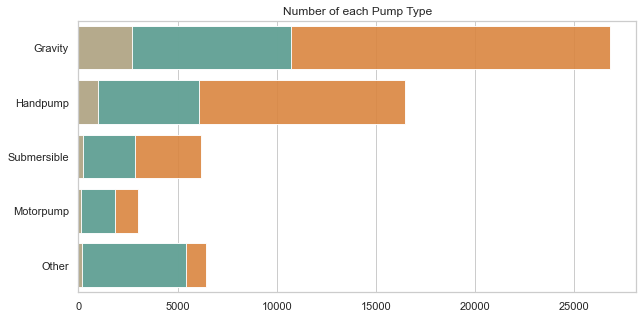

In [20]:
count_rfun = dv[dv['target'] == 'functional needs repair']['extraction_type_class']
count_nfun = pd.concat([dv[dv['target'] == 'non functional']['extraction_type_class'], count_rfun])
count_fun = pd.concat([dv[dv['target'] == 'functional']['extraction_type_class'], count_nfun])

sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
plt.figure(figsize = (10,5))
order = ['gravity', 'handpump', 'submersible', 'motorpump', 'other',]
colors = ['#f48225', '#4eb4ac', '#c7ad82']
xlabel = ''
ylabel = ''
yticks = ['Gravity', 'Handpump', 'Submersible', 'Motorpump', 'Other']
sns.countplot(y = count_fun, orient = 'v', color = colors[0], order = order, alpha = 0.9)
sns.countplot(y = count_nfun, orient = 'v', color = colors[1], order = order, alpha = 0.9)
ax = sns.countplot(y = count_rfun, orient = 'v', color = colors[2], order = order, alpha = 0.9)
ax.set(xlabel = xlabel, ylabel = ylabel, yticklabels = yticks)
ax.set_title('Number of each Pump Type')

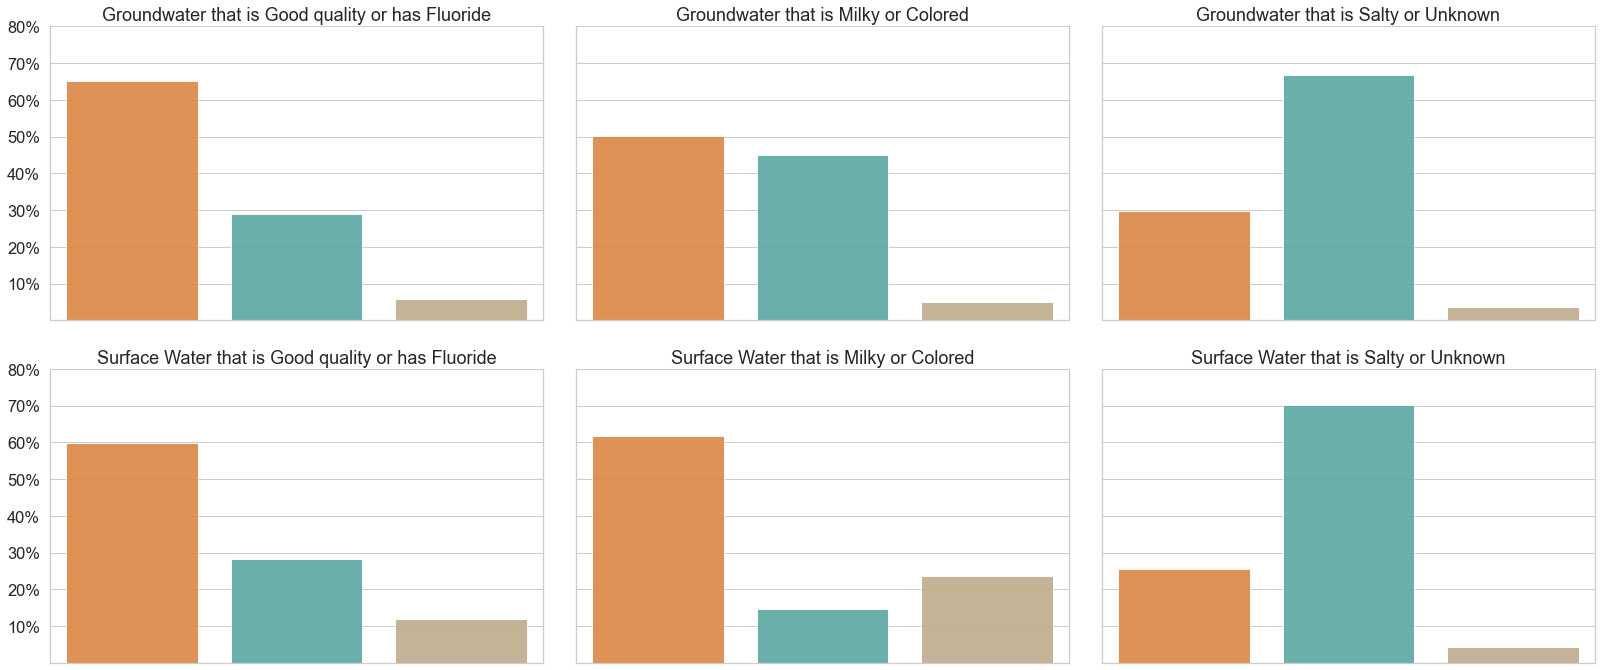

In [25]:
percents = []
cats = dv[dv['source_class'] != 'unknown']
q_0 = ['good', 'fluoride']
q_1 = ['milky', 'colored']
q_2 = ['salty', 'unknown']
for i in cats['source_class'].unique():
    for j in cats['quality_group'].unique():
        tmp = cats[(cats['source_class'] == i) & (cats['quality_group'] == j)]
        percent_sum = tmp.target.value_counts().sort_index().values.sum()
        percent_name = tmp.target.value_counts().sort_index()
        percent = tmp.target.value_counts().sort_index().values/ percent_sum
        if (len(percent) < 3):
            percent = np.concatenate((percent, [0]))
        percents.append([i,j, 'functional', percent[0]])
        percents.append([i,j, 'non functional', percent[2]])
        percents.append([i,j, 'functional needs repair', percent[1]])
        
pf = pd.DataFrame(percents, columns = ['Source', 'quality_group', 'target', 'Percentage'])
pf['Source'] = pf['Source'].str.capitalize()
pf['Source'].replace('Surface', 'Surface Water', inplace = True)
pf.loc[(pf['quality_group'] == q_0[0]) | (pf['quality_group'] == q_0[1]), 'Quality'] = f'{q_0[0].capitalize()} quality or has {q_0[1].capitalize()}'
pf.loc[(pf['quality_group'] == q_1[0]) | (pf['quality_group'] == q_1[1]), 'Quality'] = f'{q_1[0].capitalize()} or {q_1[1].capitalize()}'
pf.loc[(pf['quality_group'] == q_2[0]) | (pf['quality_group'] == q_2[1]), 'Quality'] = f'{q_2[0].capitalize()} or {q_2[1].capitalize()}'

sns.set(context = 'notebook', style = 'whitegrid', font_scale=1.5)
colors = ['#f48328', '#4eb4ac', '#c7ad82']
xlabel = ''
ylabel = ''
xticks = ''
yticks = ['', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%']
ax = sns.catplot(data = pf, x = 'target', y = 'Percentage', kind = 'bar', row = 'Source', col = 'Quality', ci = None, palette = colors, alpha = 0.9, height = 5, aspect = 1.5)
ax.set(xticklabels = xticks, yticklabels = yticks, xlabel = xlabel, ylabel = ylabel, ylim = (0, 0.8))
ax.despine(top = True, left = False, right = False)
ax.set_titles("{row_name} that is {col_name}")

## Preprocess Data for Model

#### Train Test Split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

#### Functions to impute, scale and onehotencode

In [57]:
def preprocess_training_data(X_train):
    # Split Data into Continuous and Categorical
    X_train_cat = X_train.select_dtypes(include='object')
    X_train_cont = X_train.select_dtypes(exclude='object')
    
    # Simple Imputer to fill NA numeric values using fit and transform
    si = SimpleImputer()
    X_train_imp = pd.DataFrame(si.fit_transform(X_train_cont), index = X_train_cont.index, columns = X_train_cont.columns)
    
    # Standard Scaler to scale numeric values
    ss = StandardScaler()
    X_train_sc = pd.DataFrame(ss.fit_transform(X_train_imp), index = X_train_imp.index, columns = X_train_imp.columns)
    
    # OneHotEncoder to create features from categorcal data
    ohe = OneHotEncoder(drop = 'if_binary', sparse = False)
    X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_cat),
                               columns = ohe.get_feature_names(X_train_cat.columns), index = X_train_cat.index)
    
    X_train_fin = X_train_sc.join(X_train_ohe)
    
    return X_train_fin, si, ss, ohe

In [58]:
def preprocess_testing_data(X_test, si, ss, ohe):
    # Split Data into Continuous and Categorical
    X_test_cat = X_test.select_dtypes(include='object')
    X_test_cont = X_test.select_dtypes(exclude='object')
    
    # Simple Imputer to fill NA numeric values using transform (NOT FITTING ON TESTING DATA)
    X_test_imp = pd.DataFrame(si.transform(X_test_cont), index = X_test_cont.index, columns = X_test_cont.columns)
    
    # Standard Scaler to scale numeric values
    X_test_sc = pd.DataFrame(ss.transform(X_test_imp), index = X_test_imp.index, columns = X_test_imp.columns)
    
    # OneHotEncoder to create features from categorcal data
    X_test_ohe = pd.DataFrame(ohe.transform(X_test_cat),
                              columns = ohe.get_feature_names(X_test_cat.columns), index = X_test_cat.index)
    
    # Join back numeric and categorical dataframes
    X_test_fin = X_test_sc.join(X_test_ohe)
    
    return X_test_fin

In [59]:
# Fuction takes in X_train and performs Simple Imputer, Standard Scaler, and OneHotEncoding Fit and Tranforms Data
X_train_fin, si, ss, ohe = preprocess_training_data(X_train)

In [60]:
# Fuction takes in X_test, and fitted Simple Imputer , Standard Scaler, and OneHotEncoding Objects and Transforms Data
X_test_fin = preprocess_testing_data(X_test, si, ss, ohe)

In [61]:
print('Features Count: ', X_train_fin.shape[1])

Features Count:  304


## First Simple Model

In [47]:
def plot_model_score(x):
    # data entries

    # first simple model
    fsm = ['FSM', 0.75, 0.68, 0.56, 0.57, 0.74, 0.75, 0.73]
    # logistic regression
    lr = ['LR', 0.64, 0.59, 0.66, 0.58, 0.75, 0.64, 0.68]
    # decision tree
    dt = ['DT', 0.74, 0.63, 0.66, 0.64, 0.76, 0.74, 0.75]
    # knn
    knn = ['KNN', 0.75, 0.64, 0.68, 0.66, 0.77, 0.75, 0.76]
    # voting ensemble
    ve = ['VE', 0.76, 0.66, 0.70, 0.67, 0.78, 0.76, 0.77]
    # light gradient boost
    lgb = ['LGB', 0.78, 0.68, 0.71, 0.69, 0.79, 0.78, 0.79]
    # random forest ensemble
    rf = ['RF', 0.78, 0.68, 0.70, 0.69, 0.79, 0.78, 0.79]

    # ada boost
    ab = ['AB', 0.64, 0.58, 0.64, 0.57, 0.73, 0.64, 0.67]
    # averaging ensemble
    ae = ['AE', 0.76, 0.65, 0.69, 0.66, 0.78, 0.76, 0.77]
    # cat boost
    cb = ['CB', 0.75, 0.65, 0.71, 0.66, 0.79, 0.75, 0.77]
    # gradient boost
    gb = ['GB', 0.69, 0.61, 0.66, 0.60, 0.75, 0.69, 0.71]
    # stacking all 11 models
    st = ['ST', 0.75, 0.65, 0.69, 0.66, 0.77, 0.75, 0.76]

    # order of our presentation slides
    scores = [fsm, lr, dt, knn, ve, ae, rf, ab, gb, lgb, cb, st]
    ds = pd.DataFrame(data = scores, columns = ['model', 'accuracy', 'precision_macro_avg', 'recall_macro_avg', 'f1-score_macro_avg', 'precision_weighted_avg', 'recall_weighted_avg', 'f1-score_weighted_avg'])
    
    sns.set(context = 'poster', style = 'whitegrid')
    if x > ds.shape[0]: return False
    plt.figure(figsize = (10,5))
    title = 'Model Score'
    xlabel = ''
    ylabel = ''
    ylim = (0.55, 0.8)
    colors = [ 'black', '#f48328', '#4eb4ac', '#c7ad82', '#f48328', '#4eb4ac', '#c7ad82']
    plot_cols = ['accuracy', 'precision_macro_avg', 'recall_macro_avg', 'f1-score_macro_avg']
    marker_size = 7
    if x == 1: marker_size = 10
    counter = 0
    fg, ax = plt.subplots(figsize = (20,10))
    plot_df = ds.head(x)
    
    for i in plot_cols:
        sns.lineplot(x = 'model', y= i, data = plot_df, color = colors[counter], linewidth = 4, ax = ax)
        sns.swarmplot(x = 'model', y= i, data = plot_df, size = marker_size, color = colors[counter], ax = ax)
        counter += 1

    ax.set(title = title, xlabel = xlabel, ylabel = ylabel, ylim = ylim)
#     plt.savefig(f'{x}_model_{plot_df.model[x-1]}', dpi=300, bbox_inches='tight')

    plt.show()
    return True

#### Logistic Regression

In [39]:
lr = LogisticRegression(max_iter=1000, random_state = 42)
lr.fit(X_train_fin, y_train)

NameError: name 'X_train_fin' is not defined

#### Score model on training data

In [63]:
# Score on our training data
y_pred = lr.predict(X_train_fin)
print(classification_report(y_train, y_pred)) 

                         precision    recall  f1-score   support

             functional       0.73      0.90      0.81     24161
functional needs repair       0.56      0.12      0.20      3243
         non functional       0.80      0.66      0.72     17146

               accuracy                           0.75     44550
              macro avg       0.70      0.56      0.58     44550
           weighted avg       0.75      0.75      0.73     44550



#### Score model on testing data

In [64]:
# Score on our testing data
y_pred = lr.predict(X_test_fin)
print(classification_report(y_test, y_pred)) 

                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8098
functional needs repair       0.51      0.12      0.20      1074
         non functional       0.78      0.66      0.72      5678

               accuracy                           0.75     14850
              macro avg       0.68      0.56      0.57     14850
           weighted avg       0.74      0.75      0.73     14850



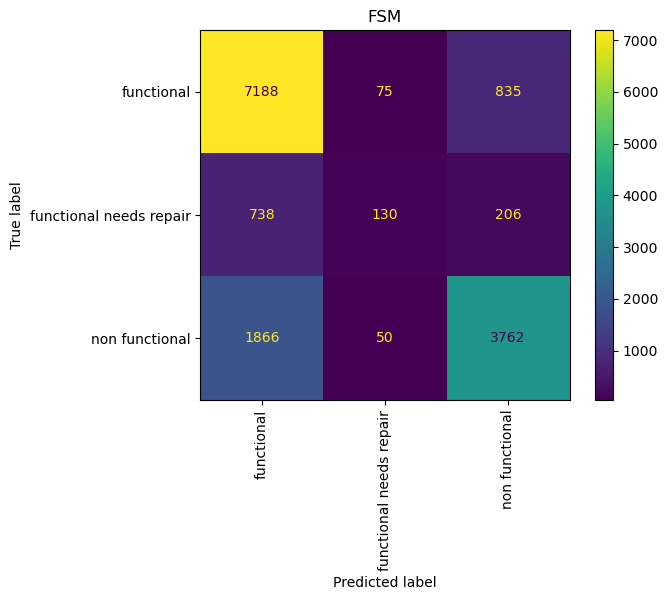

In [65]:
plt.style.use('default')
plot_confusion_matrix(lr, X_test_fin, y_test)
plt.title('FSM')
plt.xticks(rotation='vertical');

<img src = '../../reports/figures/legend_models.png' alt = 'legend_models' width = '200'>

<Figure size 720x360 with 0 Axes>

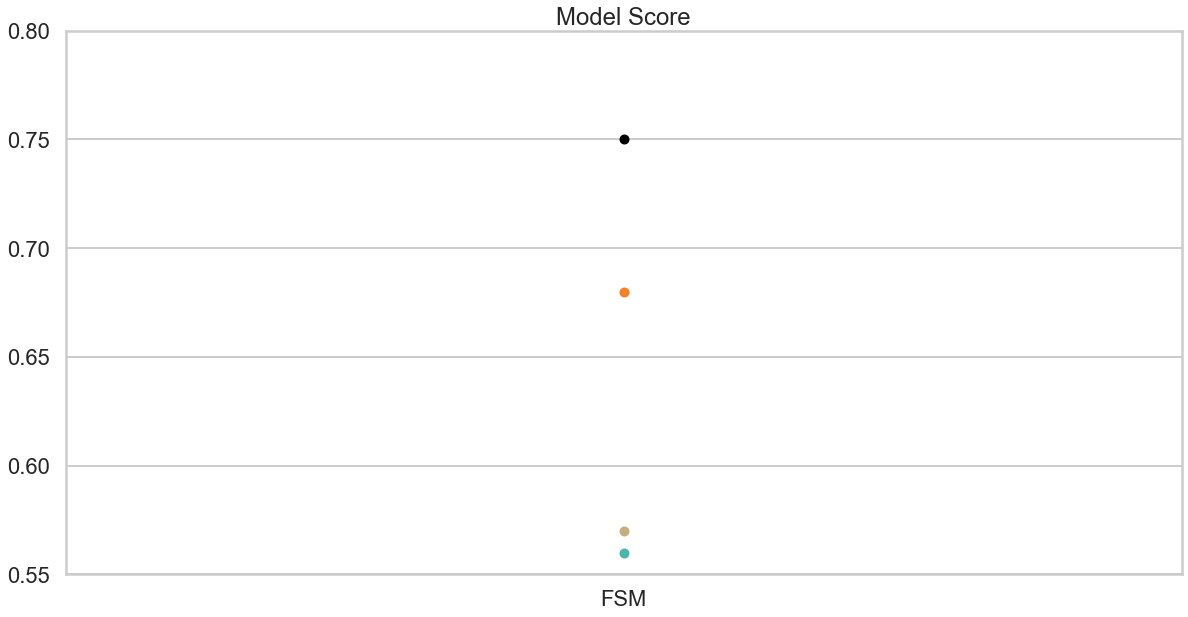

True

In [48]:
plot_model_score(1)

We can see that even though our accuracy was 75%, we are severely underpredicting the class "functional needs repair". Our f1 and recall scores are low. We need to improve upon this. Recall is important to us for the project because it tells us if we have too many false negatives. In other words, we dont want to accidently predict an nonfunctional well as functional.

#### Coefficients of Features To explore Statistically Significant Features

In [66]:
coef = pd.DataFrame(lr.coef_, columns = X_test_fin.columns).transpose()

In [67]:
coef.head(10)

0         1         2
amount_tsh         0.047915  0.018301 -0.066215
gps_height         0.027462  0.203560 -0.231022
longitude         -0.016757  0.034193 -0.017436
latitude          -0.138000  0.251070 -0.113071
num_private       -0.010930  0.015124 -0.004193
region_code       -0.082962  0.069259  0.013704
district_code      0.083414 -0.112323  0.028909
population         0.043173  0.029189 -0.072361
construction_year  0.031810 -0.089394  0.057584
basin_Internal     0.079485  0.039993 -0.119477

## Refining our Data (More Preproccesing)

#### Using Smote to Deal with Class Imbalance

In [69]:
print("Before OverSampling, counts of label 'functional needs repair': {}".format(sum(y_train == 'functional needs repair'))) 
print("Before OverSampling, counts of label 'functional': {}".format(sum(y_train == 'functional'))) 
print("Before OverSampling, counts of label 'non functional': {} \n".format(sum(y_train == 'non functional'))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
sm = SMOTE(random_state = 42) 
X_train_res, y_train_res = sm.fit_sample(X_train_fin, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label 'functional needs repair': {}".format(sum(y_train_res == 'functional needs repair'))) 
print("After OverSampling, counts of label 'functional': {}".format(sum(y_train_res == 'functional'))) 
print("After OverSampling, counts of label 'non functional': {}".format(sum(y_train_res == 'non functional')))

Before OverSampling, counts of label 'functional needs repair': 3243
Before OverSampling, counts of label 'functional': 24161
Before OverSampling, counts of label 'non functional': 17146 

After OverSampling, the shape of train_X: (72483, 304)
After OverSampling, the shape of train_y: (72483,) 

After OverSampling, counts of label 'functional needs repair': 24161
After OverSampling, counts of label 'functional': 24161
After OverSampling, counts of label 'non functional': 24161


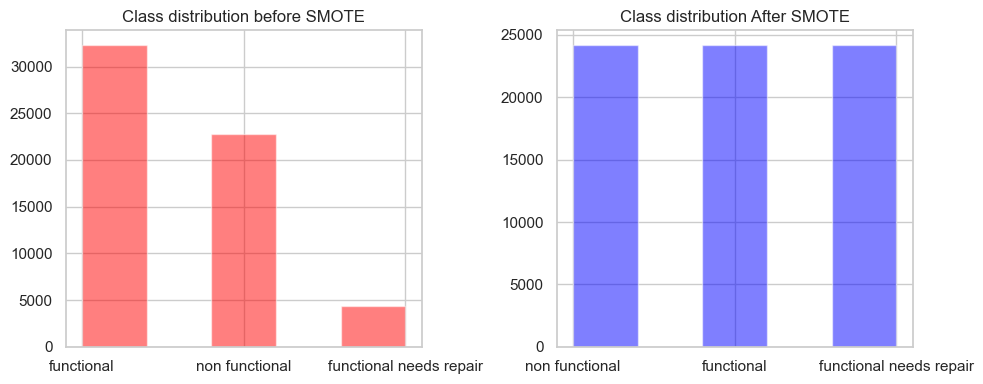

In [223]:
sns.set(context = 'notebook', style = 'whitegrid')
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4)) 
ax1.hist(y, color = 'red', alpha = .5, bins = 5)
ax1.set_title('Class distribution before SMOTE')
ax2.hist(y_train_res, color = 'blue', alpha = .5, bins = 5)
ax2.set_title('Class distribution After SMOTE')
fig.tight_layout()
plt.savefig('../../reports/figures/Fixing_class_imbalance.jpg', bbox_inches='tight');

#### Model After Smote

In [79]:
lr2 = LogisticRegression(max_iter=1000, random_state = 42)
lr2.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

In [80]:
# Score on our training data
y_pred = lr2.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.64      0.64      0.64     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.76      0.66      0.71     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [81]:
# Score on our testing data
y_pred = lr2.predict(X_test_fin)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.71      8098
functional needs repair       0.21      0.71      0.32      1074
         non functional       0.76      0.65      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.59      0.66      0.58     14850
           weighted avg       0.75      0.64      0.68     14850



Our accuracy is now more even across classes. The f1-score and recall scores really improved. Considering our model is working much better on our training data than our testing data, we could use regularization techniques to avoid overfitting.

#### Dealing with Multicollinearity
Some investigators use correlation coefficients cutoffs of 0.5 and above but most typical cutoff is 0.80

In [82]:
# heheX_train_res, y_train_res, X_test_fin, y_test

In [83]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(X_train_res, 50))

Top Absolute Correlations
extraction_type_mono                extraction_type_group_mono               1.000000
extraction_type_other               extraction_type_class_other              1.000000
quantity_unknown                    quantity_group_unknown                   1.000000
extraction_type_nira/tanira         extraction_type_group_nira/tanira        1.000000
waterpoint_type_hand pump           waterpoint_type_group_hand pump          1.000000
waterpoint_type_cattle trough       waterpoint_type_group_cattle trough      1.000000
extraction_type_other - rope pump   extraction_type_group_rope pump          1.000000
extraction_type_group_gravity       extraction_type_class_gravity            1.000000
source_type_other                   source_class_unknown                     1.000000
water_quality_milky                 quality_group_milky                      1.000000
source_rainwater harvesting         source_type_rainwater harvesting         1.000000
payment_never pay           

In [84]:
top_corrs = get_top_abs_correlations(X_train_res, 47) #Dropping columns with correlation of 1

In [85]:
features_to_drop = [pair[1] for pair in top_corrs.index]

In [86]:
# Remove Duplicates from list
features_to_drop = list(dict.fromkeys(features_to_drop))

In [87]:
X_train_res.drop(features_to_drop, axis=1, inplace=True)

In [88]:
X_test_fin.drop(features_to_drop, axis=1, inplace=True)

#### Feature Selection

In [89]:
#use inbuilt class feature_importances of tree based classifiers
model = ExtraTreesClassifier()
model.fit(X_train_res,y_train_res)

ExtraTreesClassifier()

In [218]:
# print(model.feature_importances_) 
feature_importance_df = pd.DataFrame(model.feature_importances_, index=X_train_res.columns).sort_values(by = 0, ascending = True)
feature_importance_df.head(10)

0
recorded_by_GeoData Consultants Ltd        0.000000e+00
scheme_management_None                     1.713202e-07
lga_Lindi Urban                            5.740401e-06
waterpoint_type_dam                        6.402775e-06
extraction_type_other - mkulima/shinyanga  8.317372e-06
lga_Nyamagana                              2.026405e-05
lga_Kigoma Urban                           3.684225e-05
extraction_type_climax                     3.835760e-05
water_quality_fluoride abandoned           4.804957e-05
management_other - school                  6.355497e-05

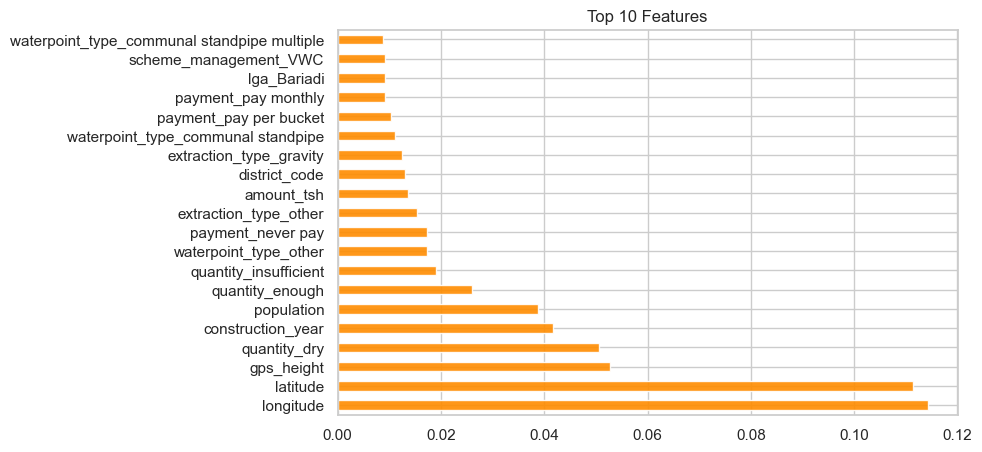

In [219]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_res.columns)
fig, ax = plt.subplots(figsize = (8,5))
feat_importances.nlargest(20).plot(kind='barh', color = "darkorange", alpha = .9)
ax.set(title = 'Top 10 Features')
plt.savefig('../../reports/figures/Top10_FeatureImportance.jpg', bbox_inches='tight');

#### Filtered feature selection

In [102]:
print('Feature count: ', X_train_res.shape[1])

Feature count:  261


In [103]:
# Filter training and testing data with largest features
# Decided to use them all since that gave us the best results in the end
X_train_filt = X_train_res[feat_importances.nlargest(261).index]
X_test_filt = X_test_fin[feat_importances.nlargest(261).index]

In [104]:
print('Feature count: ', X_train_filt.shape[1])

Feature count:  261


Model is working best when we use all the features

# Grid Search For Hyperparameter Tuning

In [ ]:
# Logistic Regression
g1 = {
    'max_iter': [ 100, 1000, 10000],
    'C': [ 0.1, 1.0, 10, 100],
    'tol': [ 10, 100, 1000],
}

gs1 = GridSearchCV(LogisticRegression(), g1)
gs1.fit(X_train_f, y_train_f)

In [ ]:
gs1.best_estimator_

In [63]:
# LogisticRegression(C=10, max_iter=1000, tol=10)

In [ ]:
gs1.best_score_

In [ ]:
# 0.64

In [ ]:
# KNN
g2 = {
    'n_neighbors': [5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p' : [1,2]
}

gs2 = GridSearchCV(KNeighborsClassifier(), g2)
gs2.fit(X_train_f, y_train_f)

In [ ]:
gs2.best_estimator_

In [ ]:
# KNeighborsClassifier(p=1, weights='distance')

In [ ]:
gs2.best_score_

In [ ]:
0.8322645948594678

In [ ]:
# decision trees
g3 = {
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf' : [1,2,3]
}

gs3 = GridSearchCV(DecisionTreeClassifier(), g3)
gs3.fit(X_train_f, y_train_f)

In [ ]:
gs3.best_estimator_

In [ ]:
# DecisionTreeClassifier(max_depth=9, min_samples_split=3)

In [ ]:
gs3.best_score_

In [ ]:
# 0.6541672338845779

In [ ]:
# random forest
g4 = {
    'max_depth': [ 2, 5, 10 ],
    'n_estimators': [ 100, 1000, 2000]
}

gs4 = GridSearchCV(RandomForestClassifier(), g4)
gs4.fit(X_train_f, y_train_f)

In [ ]:
gs4.best_estimator_

In [ ]:
# RandomForestClassifier(max_depth=10, n_estimators=2000)

In [ ]:
gs4.best_score_

In [ ]:
# 0.7201414464452643

# Modeling with our Refined Data

Using hyperparameters from Andrew's tuning

#### Logistic Regression

In [105]:
lr3 = LogisticRegression(C=10, max_iter=1000, tol=10, random_state=42)
lr3.fit(X_train_filt, y_train_res)

LogisticRegression(C=10, max_iter=1000, random_state=42, tol=10)

In [106]:
# Score on our training data
y_pred = lr3.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.64      0.64      0.64     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.76      0.66      0.71     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [107]:
# Score on our testing data
y_pred = lr3.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.70      8098
functional needs repair       0.21      0.71      0.32      1074
         non functional       0.76      0.65      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.59      0.66      0.58     14850
           weighted avg       0.75      0.64      0.68     14850



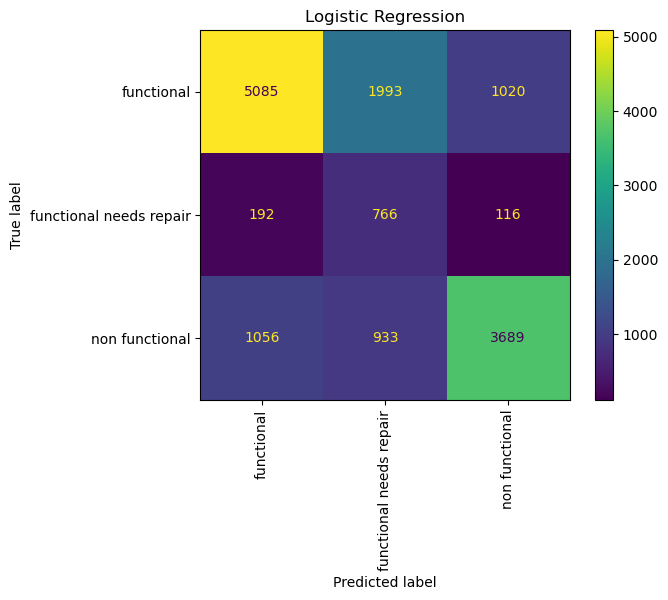

In [108]:
plt.style.use('default')
plot_confusion_matrix(lr3, X_test_filt, y_test)
plt.title('Logistic Regression')
plt.xticks(rotation='vertical');

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 720x360 with 0 Axes>

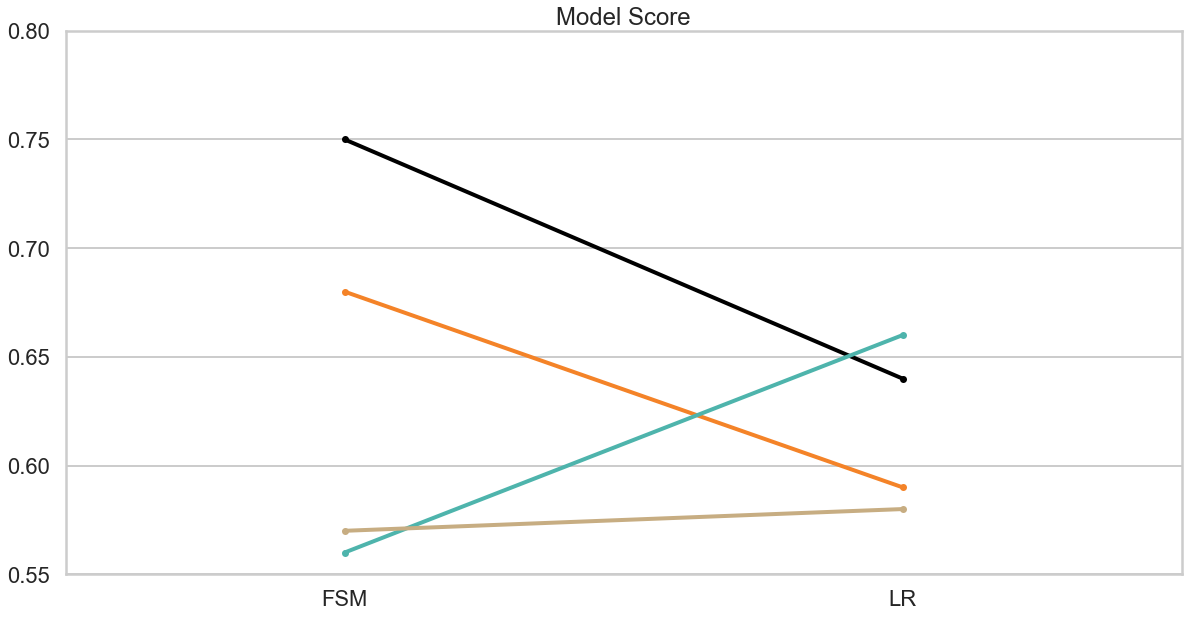

True

In [49]:
plot_model_score(2)

#### Decision Tree

In [115]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_filt, y_train_res)

DecisionTreeClassifier(random_state=42)

In [116]:
# Score on our training data
y_pred = dt.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       1.00      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [117]:
# Score on our testing data
y_pred = dt.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.77      0.79      8098
functional needs repair       0.33      0.47      0.39      1074
         non functional       0.77      0.76      0.76      5678

               accuracy                           0.74     14850
              macro avg       0.64      0.67      0.65     14850
           weighted avg       0.76      0.74      0.75     14850



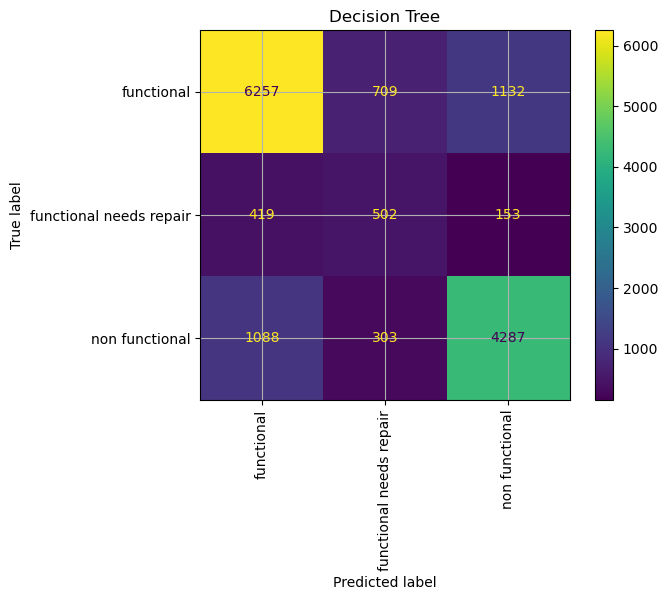

In [118]:
plot_confusion_matrix(dt, X_test_filt, y_test)
plt.title('Decision Tree')
plt.xticks(rotation='vertical')
plt.grid();

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 720x360 with 0 Axes>

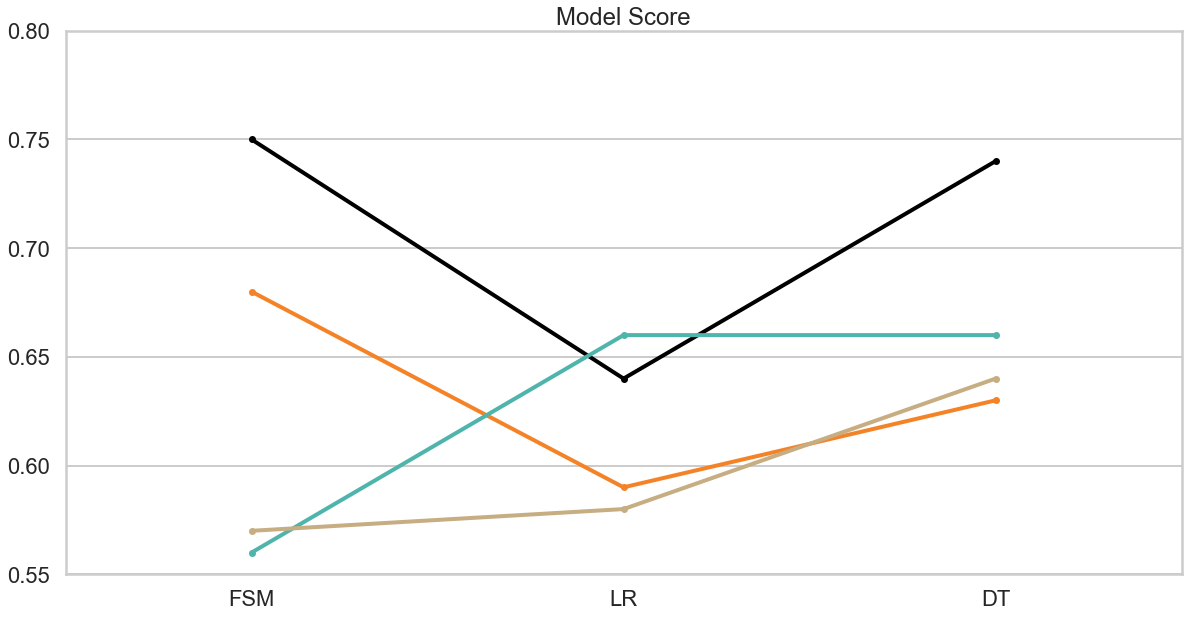

True

In [50]:
plot_model_score(3)

#### KNN

In [111]:
knn1 = KNeighborsClassifier(n_neighbors = 5, p=1, weights='distance')
knn1.fit(X_train_filt, y_train_res)

KNeighborsClassifier(p=1, weights='distance')

In [112]:
# Score on our training data
y_pred = knn1.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.99      0.99      0.99     24161
functional needs repair       0.99      0.99      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           0.99     72483
              macro avg       0.99      0.99      0.99     72483
           weighted avg       0.99      0.99      0.99     72483



In [113]:
# Score on our testing data
y_pred = knn1.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.77      0.79      8098
functional needs repair       0.34      0.52      0.41      1074
         non functional       0.78      0.76      0.77      5678

               accuracy                           0.75     14850
              macro avg       0.64      0.68      0.66     14850
           weighted avg       0.77      0.75      0.76     14850



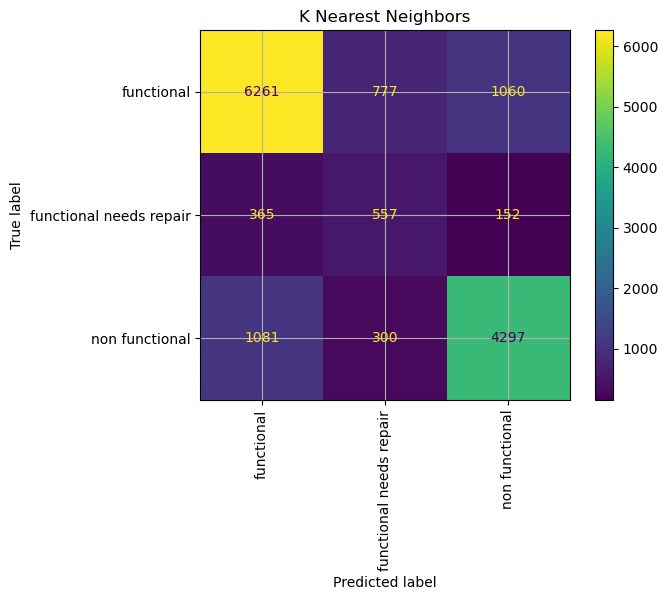

In [114]:
plot_confusion_matrix(knn1, X_test_filt, y_test)
plt.title('K Nearest Neighbors')
plt.xticks(rotation='vertical')
plt.grid();

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 720x360 with 0 Axes>

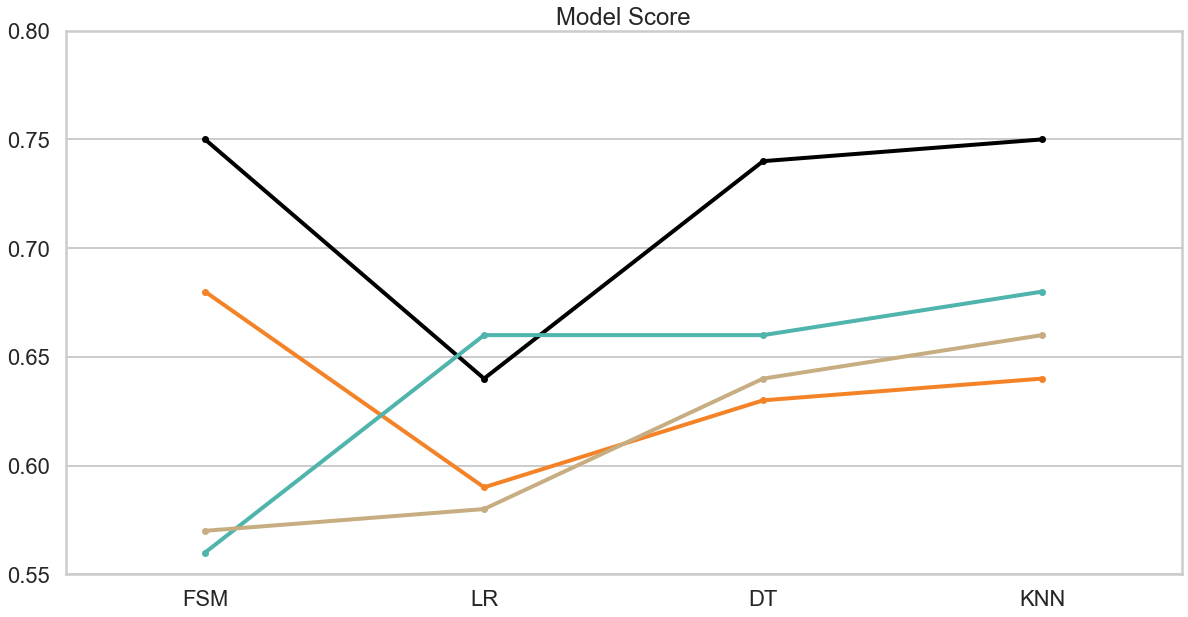

True

In [51]:
plot_model_score(4)

## Ensemble Methods

Voting and Averaging are "weak" estimators. They are useful in the case that the models are already accurate

#### Voting Ensemble

To explain the idealogy behind voting ensembles, I'll start with an analagy. In a game show like who wants to be a millionare, a contestant can choose to "ask the audience". The contestant usually chooses the answer most voted for by the audience. According to stats from TV studios, the audience chooses the right answer over 90% of the time. This is due to a concept known as "wisdom of the crowds" referring to the collective intelligence of a group being superior to a single expert. Voting Ensembles use wisdom of the crowds to make its prediction based on the mode (or majority prediction) of multiple individual models.

In [119]:
#Base estimators
# lr3 - linear regression model
# knn1 - knn model
# dt - decision tree model
# etc - extra trees classifier model

clf_voting = VotingClassifier(
    estimators = [
        ('linear regression', lr3),
        ('K Nearest Neighbors', knn1),
        ('Decision Tree', dt)])

In [120]:
clf_voting.fit(X_train_filt, y_train_res)

VotingClassifier(estimators=[('linear regression',
                              LogisticRegression(C=10, max_iter=1000,
                                                 random_state=42, tol=10)),
                             ('K Nearest Neighbors',
                              KNeighborsClassifier(p=1, weights='distance')),
                             ('Decision Tree',
                              DecisionTreeClassifier(random_state=42))])

In [121]:
# Score on our training data
y_pred = clf_voting.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.99      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [122]:
# Score on our testing data
y_pred = clf_voting.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.80      0.81      8098
functional needs repair       0.34      0.53      0.42      1074
         non functional       0.82      0.75      0.78      5678

               accuracy                           0.76     14850
              macro avg       0.66      0.70      0.67     14850
           weighted avg       0.78      0.76      0.77     14850



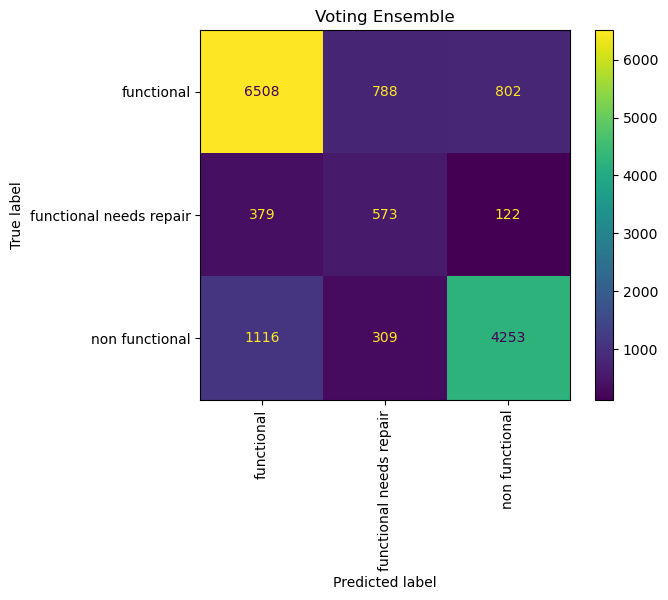

In [123]:
plot_confusion_matrix(clf_voting, X_test_filt, y_test)
plt.title('Voting Ensemble')
plt.xticks(rotation='vertical');

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 720x360 with 0 Axes>

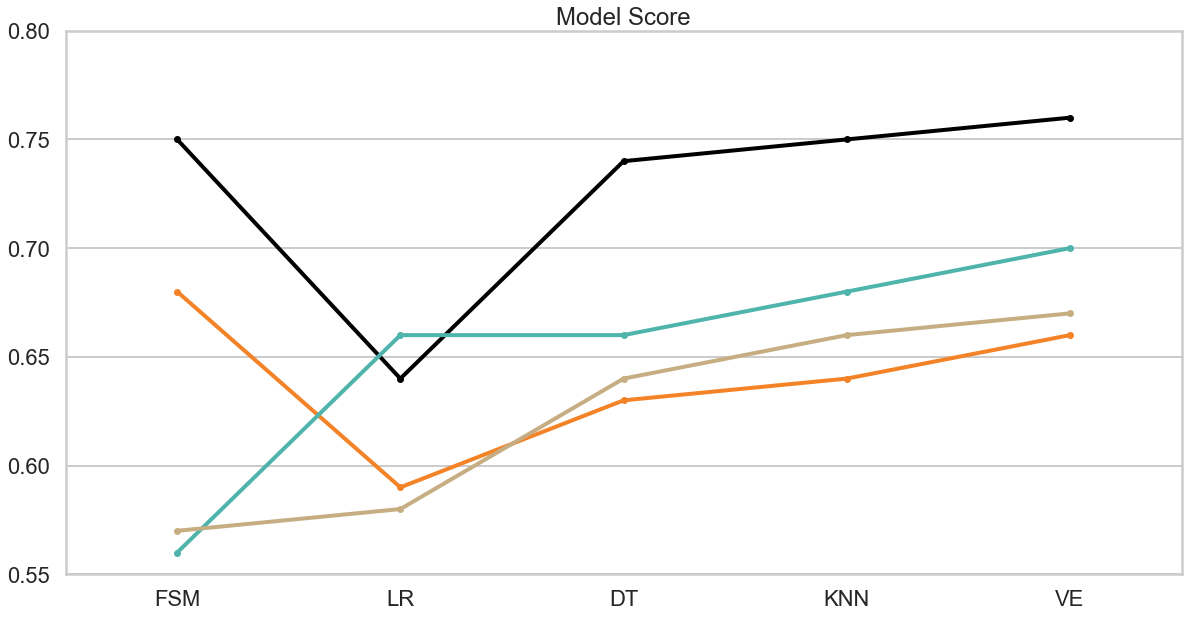

True

In [52]:
plot_model_score(5)

#### Averaging Classifier

Similar to Voting but with specifying voting parameter to soft. Can assign different weights to each model

In [124]:
#Base estimators
# lr3 - linear regression model
# knn1 - knn model
# dt - decision tree model
# etc - extra trees classifier model

clf_averaging = VotingClassifier(
    estimators = [
        ('linear regression', lr3),
        ('K Nearest Neighbors', knn1),
        ('Decision Tree', dt)],
    voting = 'soft',
)
clf_averaging.fit(X_train_filt, y_train_res)

VotingClassifier(estimators=[('linear regression',
                              LogisticRegression(C=10, max_iter=1000,
                                                 random_state=42, tol=10)),
                             ('K Nearest Neighbors',
                              KNeighborsClassifier(p=1, weights='distance')),
                             ('Decision Tree',
                              DecisionTreeClassifier(random_state=42))],
                 voting='soft')

In [125]:
# Score on our training data
y_pred = clf_averaging.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.99      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [126]:
# Score on our testing data
y_pred = clf_averaging.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.79      0.80      8098
functional needs repair       0.35      0.50      0.41      1074
         non functional       0.80      0.76      0.78      5678

               accuracy                           0.76     14850
              macro avg       0.65      0.69      0.66     14850
           weighted avg       0.78      0.76      0.77     14850



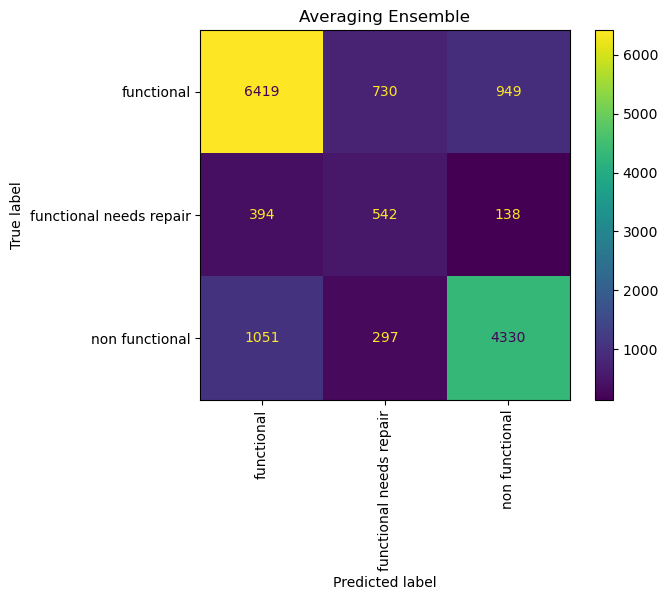

In [127]:
plot_confusion_matrix(clf_averaging, X_test_filt, y_test)
plt.title('Averaging Ensemble')
plt.xticks(rotation='vertical');

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 720x360 with 0 Axes>

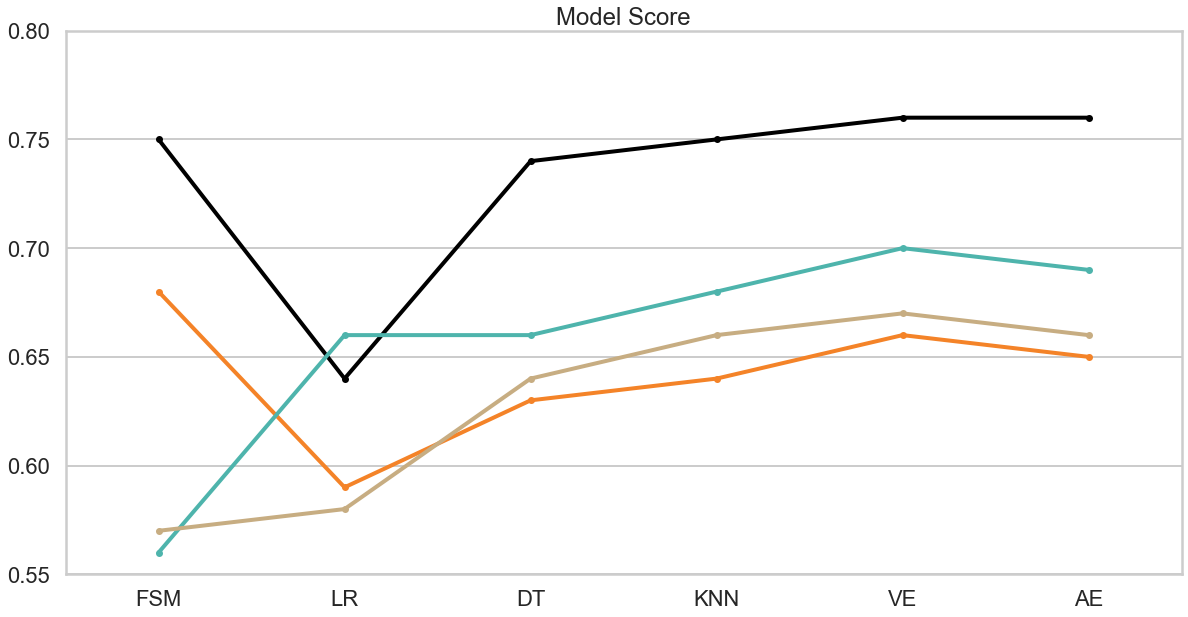

True

In [53]:
plot_model_score(6)

#### Random Forest Classifier
Combines many decision trees into a forest of trees which use different samples of the data and features

In [128]:
rfc = RandomForestClassifier(n_estimators=2000, random_state=42)
rfc.fit(X_train_filt,y_train_res)

RandomForestClassifier(n_estimators=2000, random_state=42)

In [129]:
# Score on our training data
y_pred = rfc.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       1.00      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [130]:
# Score on our testing data
y_pred = rfc.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.82      0.82      8098
functional needs repair       0.40      0.50      0.44      1074
         non functional       0.82      0.78      0.80      5678

               accuracy                           0.78     14850
              macro avg       0.68      0.70      0.69     14850
           weighted avg       0.79      0.78      0.79     14850



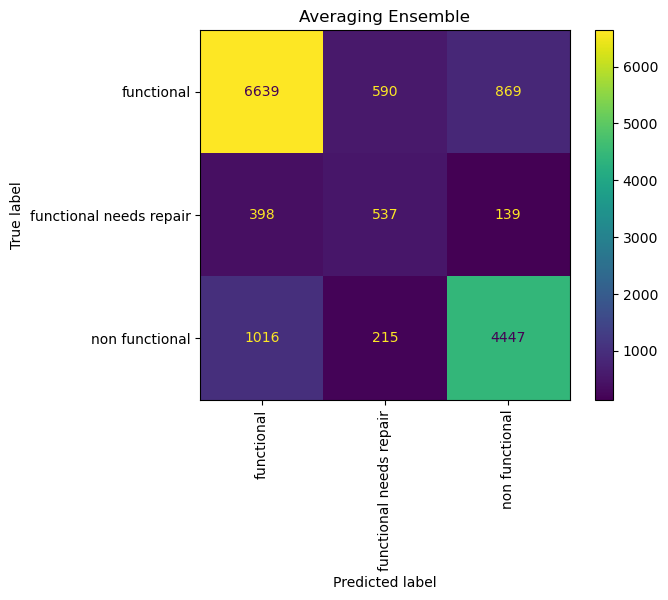

In [131]:
plot_confusion_matrix(rfc, X_test_filt, y_test)
plt.title('Averaging Ensemble')
plt.xticks(rotation='vertical');

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 720x360 with 0 Axes>

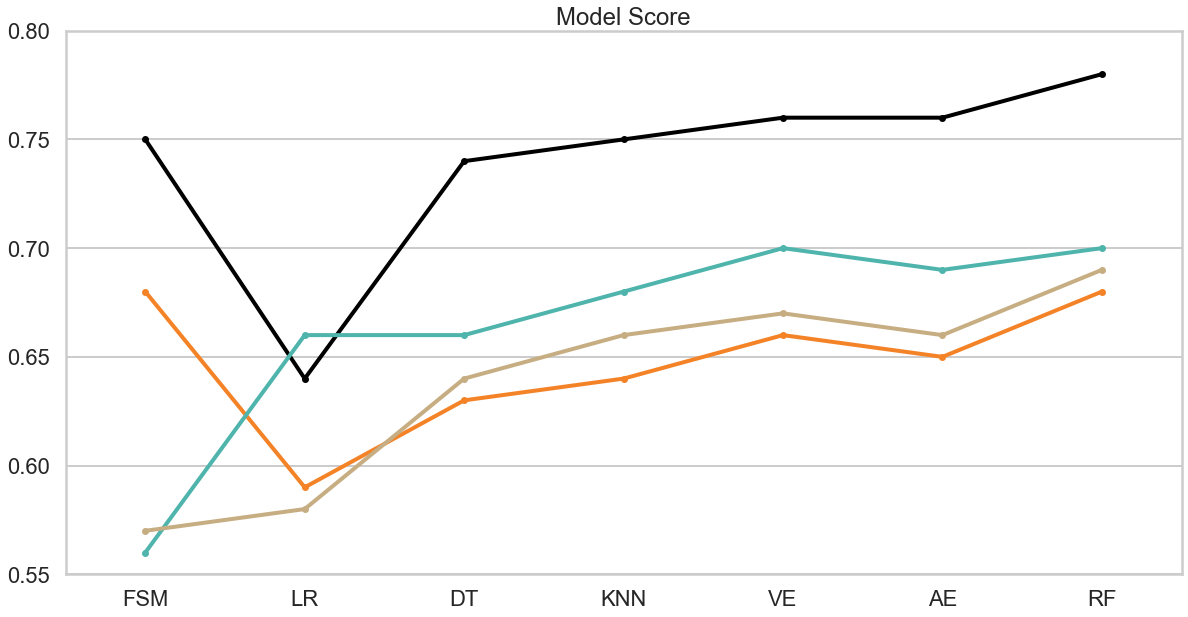

True

In [54]:
plot_model_score(7)

### Boosting Algorithms
Boosting is another ensemble method based on iterative learning and sequential model building. It's a good choice when problems are complex, we have big datasets, and we need to apply parallel processing. They use decision trees as a base model and improve upon that by n_estimators number of times with a learning rate we can also tune

#### Ada Boost Classifier
Award winning algo

In [132]:
# Instantiate an AdaBoostClassifier
# Defaults are estimator=DecisionTree, n_estimator=100, learning_rate = 1
adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_clf.fit(X_train_filt, y_train_res)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [133]:
# Score on our training data
y_pred = adaboost_clf.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.64      0.66      0.65     24161
functional needs repair       0.66      0.74      0.70     24161
         non functional       0.75      0.63      0.68     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [134]:
# Score on our testing data
y_pred = adaboost_clf.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.65      0.71      8098
functional needs repair       0.20      0.63      0.30      1074
         non functional       0.77      0.63      0.69      5678

               accuracy                           0.64     14850
              macro avg       0.58      0.64      0.57     14850
           weighted avg       0.73      0.64      0.67     14850



<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 720x360 with 0 Axes>

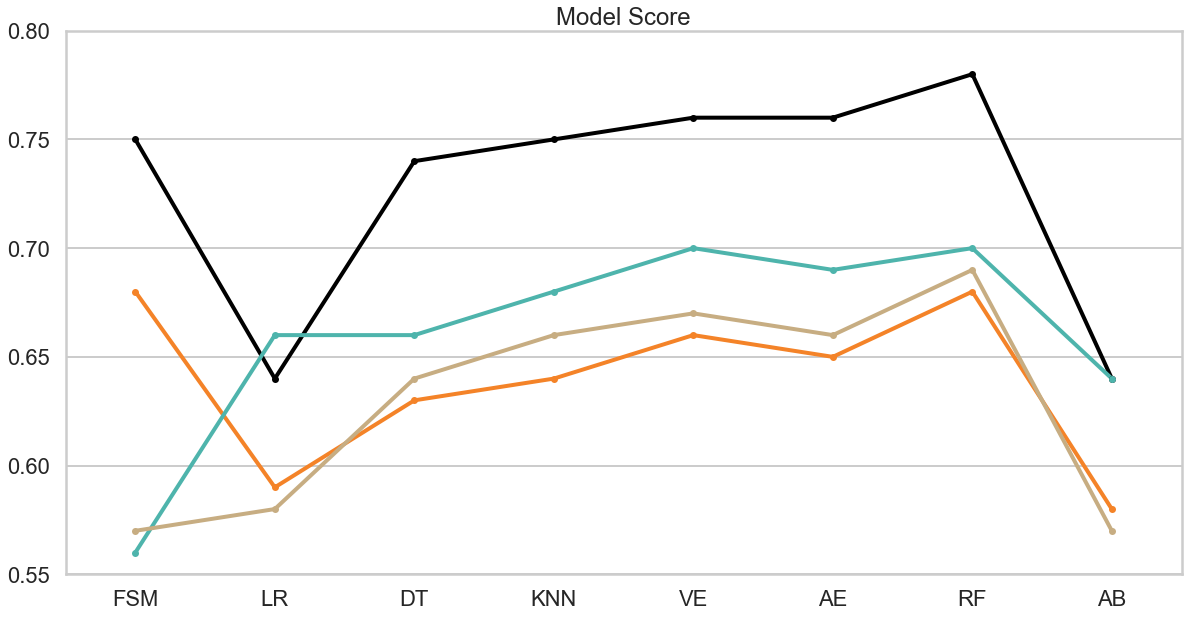

True

In [55]:
plot_model_score(8)

#### Gradient Boosting Classifier

In [135]:
# Instantiate an GradientBoostingClassifier
# We dont specify an estimator since Gradient Boosting uses regression trees
# Default params: n_estimators=100, learning_rate=0.1, mex_depth=3, min_samples_split, min_samples_leaf, max_features
# In Gradient Boosting, it is recommended to use all the features
gbt_clf = GradientBoostingClassifier(random_state=42)
gbt_clf.fit(X_train_filt, y_train_res)

GradientBoostingClassifier(random_state=42)

In [136]:
# Score on our training data
y_pred = gbt_clf.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.67      0.74      0.70     24161
functional needs repair       0.72      0.80      0.76     24161
         non functional       0.83      0.65      0.73     24161

               accuracy                           0.73     72483
              macro avg       0.74      0.73      0.73     72483
           weighted avg       0.74      0.73      0.73     72483



In [137]:
# Score on our testing data
y_pred = gbt_clf.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.73      0.75      8098
functional needs repair       0.24      0.63      0.34      1074
         non functional       0.82      0.63      0.71      5678

               accuracy                           0.69     14850
              macro avg       0.61      0.66      0.60     14850
           weighted avg       0.75      0.69      0.71     14850



#### Extreme Gradient Boosting Classifier

Optomized for distributed computing. Parallel training.

In [138]:
xgbc = xgb.XGBClassifier(max_depth=10, random_state=42)
xgbc.fit(X_train_filt,y_train_res)

XGBClassifier(max_depth=10, objective='multi:softprob', random_state=42)

In [139]:
# Score on our training data
y_pred = xgbc.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.83      0.83     24161
functional needs repair       0.83      0.93      0.88     24161
         non functional       0.91      0.80      0.85     24161

               accuracy                           0.85     72483
              macro avg       0.86      0.85      0.85     72483
           weighted avg       0.86      0.85      0.85     72483



In [140]:
# Score on our testing data
y_pred = xgbc.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.78      0.80      8098
functional needs repair       0.30      0.62      0.41      1074
         non functional       0.84      0.73      0.78      5678

               accuracy                           0.75     14850
              macro avg       0.65      0.71      0.66     14850
           weighted avg       0.79      0.75      0.76     14850



<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 720x360 with 0 Axes>

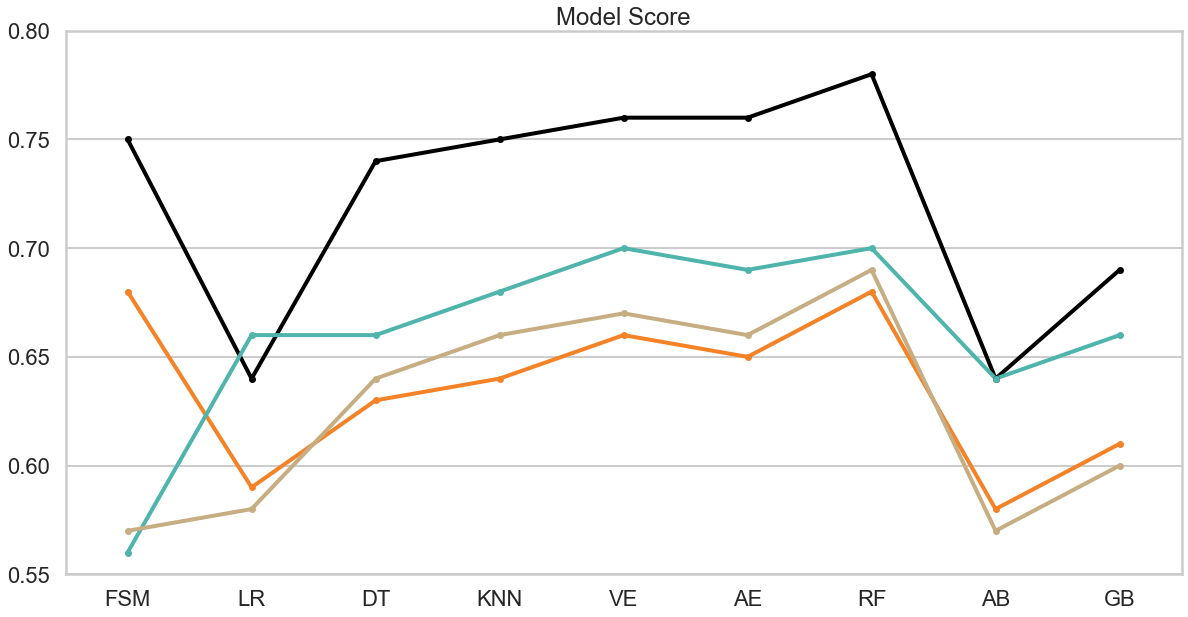

True

In [57]:
plot_model_score(9)

#### Light Gradient Boosting

Released by Microsoft in 2017
Fast and efficient. Lighter in terms of space.
Optimized for parallel and GPU processing.
Useful for big datasets.

In [141]:
# Params similar to gradient boosting except default max_depth = -1 (unlimited)
clf_lgb = lgb.LGBMClassifier(n_estimators=1000, seed=42)
clf_lgb.fit(X_train_filt,y_train_res)

LGBMClassifier(n_estimators=1000, seed=42)

In [142]:
# Score on our training data
y_pred = clf_lgb.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.90      0.90      0.90     24161
functional needs repair       0.92      0.96      0.94     24161
         non functional       0.95      0.90      0.92     24161

               accuracy                           0.92     72483
              macro avg       0.92      0.92      0.92     72483
           weighted avg       0.92      0.92      0.92     72483



In [143]:
# Score on our testing data
y_pred = clf_lgb.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.83      0.82      0.82      8098
functional needs repair       0.37      0.53      0.44      1074
         non functional       0.82      0.77      0.80      5678

               accuracy                           0.78     14850
              macro avg       0.67      0.71      0.69     14850
           weighted avg       0.79      0.78      0.78     14850



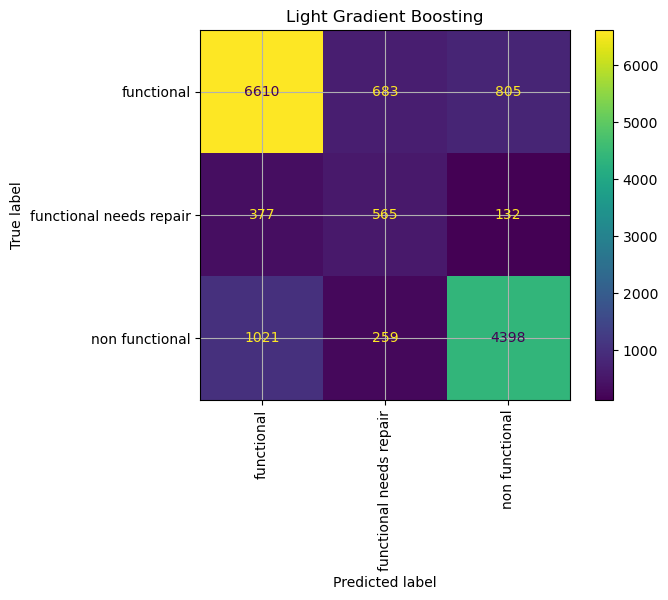

In [144]:
plot_confusion_matrix(clf_lgb, X_test_filt, y_test)
plt.title('Light Gradient Boosting')
plt.xticks(rotation='vertical')
plt.grid();

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 720x360 with 0 Axes>

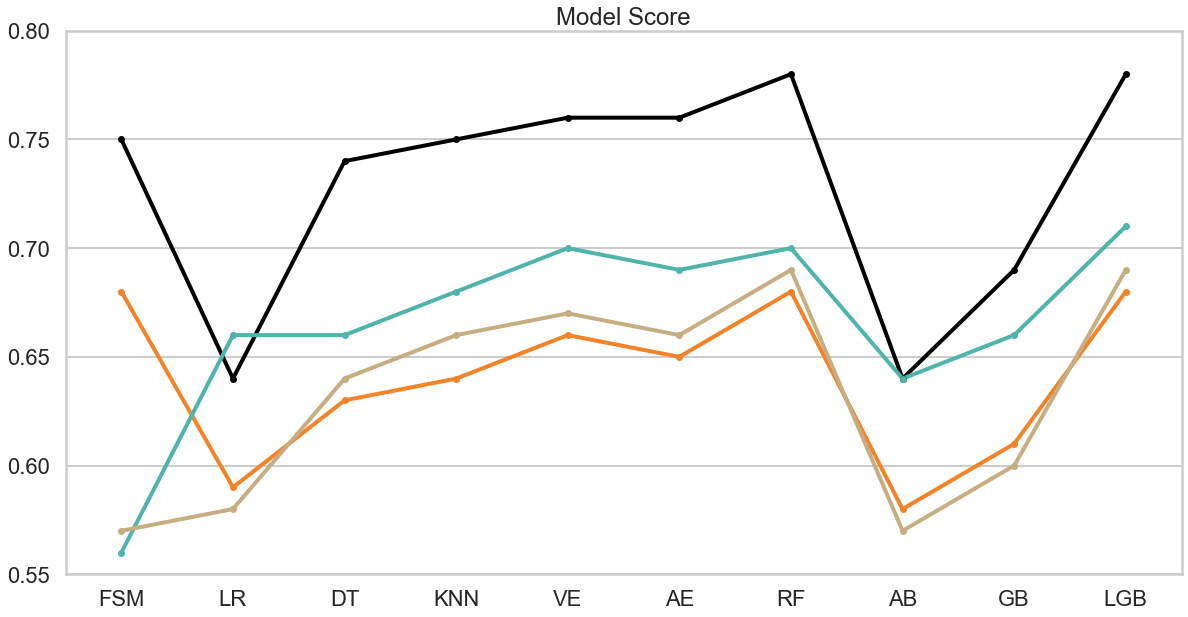

True

In [58]:
plot_model_score(10)

#### Cat Boost
Open sourced by Yandex(april 2017). Built in handling of categorical features. Accurate and robust. Fast and scalable

In [159]:
# Default Params - n_estimators=1000, learning_rate=0.1, max_depth=3, 
# reg_cat = cb.CatBoostClassifier(random_state=500)
# reg_cat.fit(X_train_filt, y_train_res)

In [152]:
# Score on our training data
y_pred = reg_cat.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.81      0.80     24161
functional needs repair       0.84      0.91      0.87     24161
         non functional       0.88      0.79      0.83     24161

               accuracy                           0.84     72483
              macro avg       0.84      0.84      0.84     72483
           weighted avg       0.84      0.84      0.84     72483



In [153]:
# # Score on our testing data
y_pred = reg_cat.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.79      0.80      8098
functional needs repair       0.32      0.59      0.41      1074
         non functional       0.83      0.74      0.78      5678

               accuracy                           0.76     14850
              macro avg       0.66      0.71      0.67     14850
           weighted avg       0.79      0.76      0.77     14850



<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 720x360 with 0 Axes>

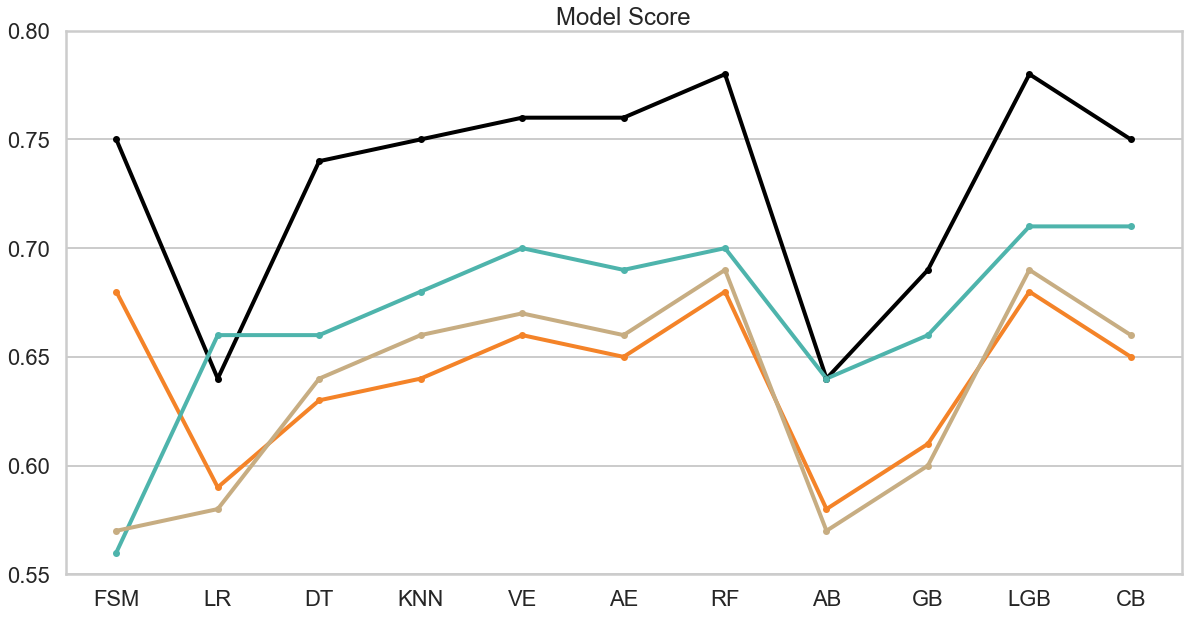

True

In [59]:
plot_model_score(11)

### Stacking

Combining models together. Good choice when Voting/Averaging dont have great results

In [154]:
# Parameters = classifiers = [clf1, clf2, clf3...], meta_classifiers=clf_meta, use_probas=False, use_features_in_secondary=False
classifiers = [lr3, knn1, dt, clf_voting, clf_averaging, rfc, adaboost_clf, gbt_clf, xgbc, clf_lgb, reg_cat]

clf_meta = clf_lgb

clf_stack = StackingClassifier(classifiers, clf_meta, use_features_in_secondary=True)

Target classes need to be numerical for StackingClassifier to work. Use Label Encoder for this

In [155]:
le = LabelEncoder()
le.fit(y_train_res)

LabelEncoder()

In [156]:
y_train_le = le.fit_transform(y_train_res)
y_test_le = le.transform(y_test)

In [158]:
clf_stack.fit(X_train_filt, y_train_le)

In [ ]:
# Score on our training data
y_pred = clf_stack.predict(X_train_filt)
print(classification_report(y_train_le, y_pred))

In [ ]:
# Score on our testing data
y_pred = clf_stack.predict(X_test_filt)
print(classification_report(y_test_le, y_pred))

In [ ]:
confusion_matrix(y_test_le, y_pred)

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 720x360 with 0 Axes>

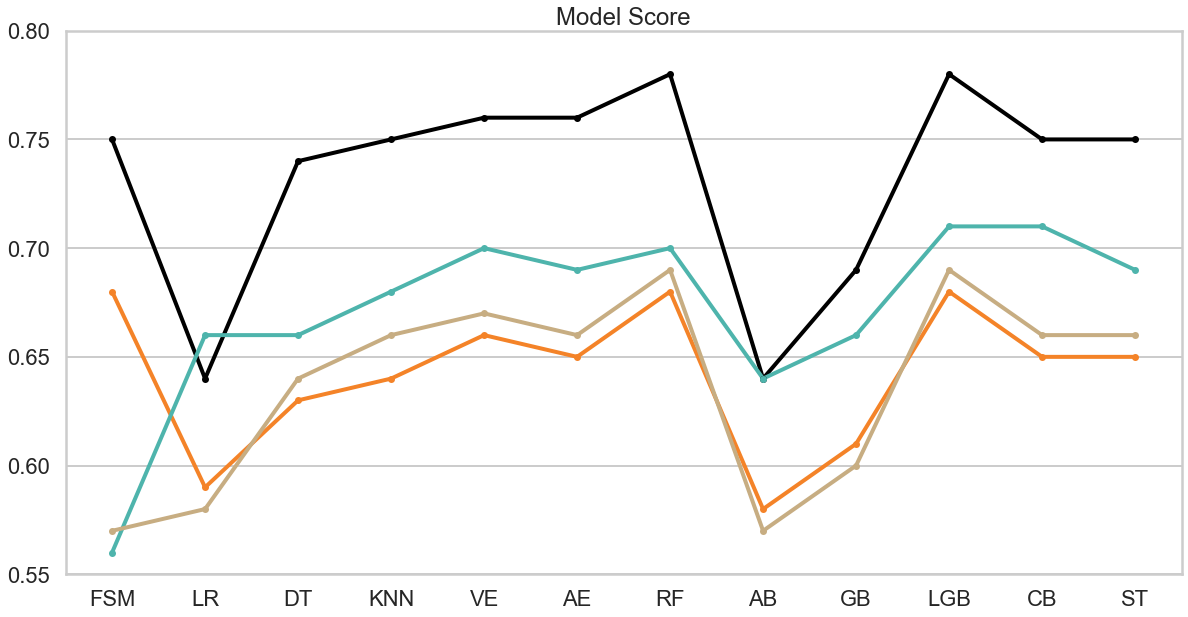

True

In [61]:
plot_model_score(12)

# Final Predictions

Turns out our stacking ensemble didn't work as well as we'd hoped. We are going with the Light Gradient Boost model as our final model

#### Preprocess unlabeled data set

In [170]:
unlabeled_df = pd.read_csv("../../references/test_set_values.csv", index_col = 'id')
unlabeled_df_geo = unlabeled_df[['longitude', 'latitude']]

# Drop the same columns as in our other data set
columns_with_na = ['permit', 'scheme_name', 'public_meeting', 'subvillage', 'installer', 'funder']
unlabeled_df.drop(columns_with_na, axis=1, inplace=True)
columns_with_specific_location_and_names = ['ward', 'wpt_name']
unlabeled_df.drop(columns_with_specific_location_and_names, axis=1, inplace=True)
unlabeled_df.drop('date_recorded', axis=1, inplace=True)

# Impute scheme_management 
unlabeled_df['scheme_management'] = unlabeled_df['scheme_management'].fillna("UNKNOWN")

In [171]:
# Call our function to preprocess our testing data
unlabeled_df = preprocess_testing_data(unlabeled_df, si, ss, ohe)

In [172]:
# Reorder the columns so it matches our training dataset
unlabeled_df = unlabeled_df[X_train_filt.columns]

#### Make our final predictions

In [173]:
# Make our final predictions
y_pred = xgbc.predict(unlabeled_df)

### Plot our Final Predictions

Create a new data frame with locations and predictions of testing data

In [174]:
y_pred_df = pd.DataFrame(y_pred, index = unlabeled_df_geo.index)
final_df = pd.concat([unlabeled_df_geo, y_pred_df], axis=1)
final_df.head()

longitude   latitude               0
id                                         
50785  35.290799  -4.059696  non functional
51630  36.656709  -3.309214      functional
17168  34.767863  -5.004344      functional
45559  38.058046  -9.418672  non functional
49871  35.006123 -10.950412      functional

#### Convert our pandas DataFrame to a GeoDataFrame

In [227]:
# Add a geometry column that holds Point objects with lat and long
final_df['geometry'] = final_df.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
final_df = gpd.GeoDataFrame(final_df, geometry='geometry')
final_df.crs = "EPSG:4326"
final_df = final_df.to_crs(epsg = 3857)

#### Make our GeoPandas Plot with our Final Predictions

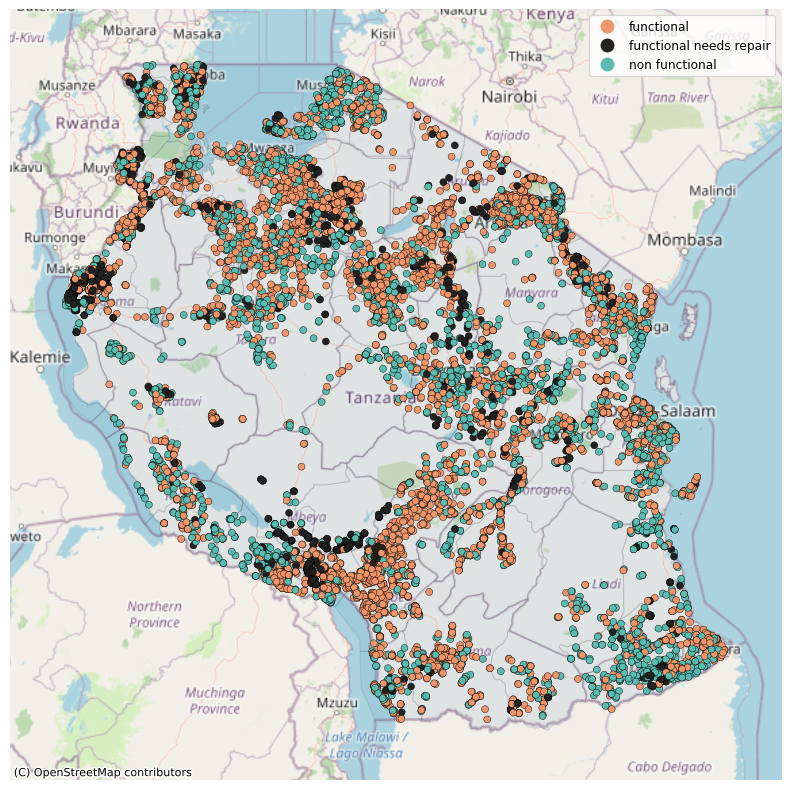

In [200]:
sns.set_context("paper", font_scale=1)
fig, ax = plt.subplots(figsize=(8,8))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

final_df.plot(ax=ax, column = 0, marker = '.', markersize=100,
         edgecolor = 'black', cmap = custom_palette,
         linewidth=.3, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Well Status Final Predictions', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_final.jpg');